# **Importing Libraries**

In [124]:
# Essential libraries
import numpy as np
import pandas as pd
# Plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')

# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import MEstimateEncoder

# stats
from scipy.stats import norm
from scipy import stats

print('Libraries have been imported.')

Libraries have been imported.


In [125]:
# import training data
df_train = pd.read_csv('data/train.csv')
#df_train = df_train.drop(columns= 'Id')
# import test data
df_test = pd.read_csv('data/test.csv')
# df_test = df_test.drop(columns='Id')

In [126]:
# tip:
# use read_csv()


## **Data Preprocessing**

**Outlier Detection**

Note:
> Outiers are ...

In [127]:
def scatterplot(df, var1, var2):
    fig, ax = plt.subplots(figsize = (8,6))
    ax.scatter(x = df[var1], y = df[var2])
    plt.ylabel(var2,fontsize = 14,fontweight='bold')
    plt.xlabel(var1,fontsize = 14,fontweight='bold')
    # changing the fontsize of y & x ticks
    plt.yticks(fontsize=14,fontweight='bold'), plt.xticks(fontsize=14,fontweight='bold')
    plt.show()

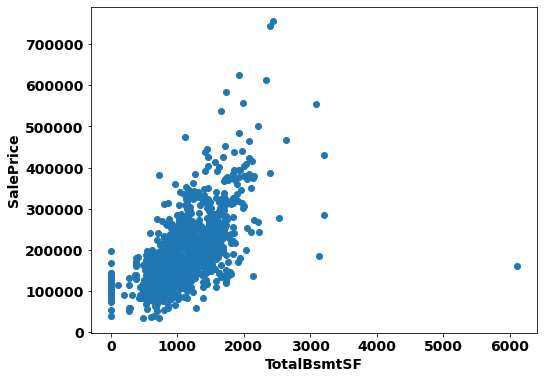

In [128]:
# Outlier Detection

#Let's check the values of our target variable together with the other numeric attributes 
# we identified as important in the previous tutorial: - TotalBsmtSF - GrLivArea

scatterplot(df = df_train, var1 = 'TotalBsmtSF', var2 = 'SalePrice')

- We can see that there is one house with a really huge basement and a cheap price. 
- This house would cause problems in modeling because, except for this one house, we can see a clear linear relationship between the size of a basement and the price of a house.
- Now we are going to remove this outlier from our dataset. 
- We will remove all observations that have more than 5,000 square feet of basement and a price lower than $300,000:

In [129]:
# outliers in TotalBsmtSF
#df_train = df_train.drop(df_train[df_train['TotalBsmtSF'] > 6000].index)
#sns.scatterplot(x= df_train['TotalBsmtSF'], y= df_train['SalePrice'])

In [130]:
# delete outliers
df_train_vis = df_train.drop(df_train[(df_train['TotalBsmtSF']>5000) & (df_train['SalePrice']<300000)].index)
# reset index
df_train_vis = df_train_vis.reset_index(drop=True)

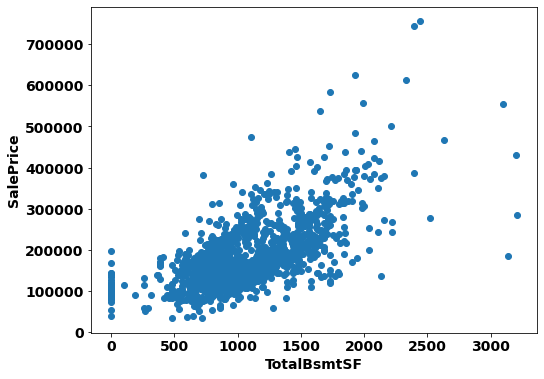

In [131]:
# check the graphic again
scatterplot(df = df_train_vis, var1 = 'TotalBsmtSF', var2 = 'SalePrice')

We can see that the relationship in the picture is much nicer now.

Let's check another numeric variable from the output of the previous tutorial: GrLivArea.

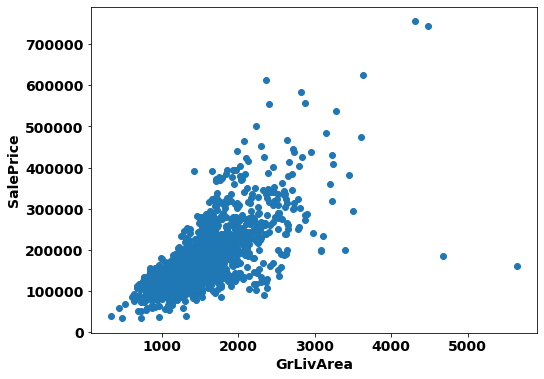

In [132]:
scatterplot(df = df_train, var1 = 'GrLivArea', var2 = 'SalePrice')

This is a good example of multivariate outliers. If we look only at GrLivArea there are no outliers because the largest area is quite close to the second and the third largest. However, if we take a look at SalePrice together with GrLivArea, we can see that the price of the largest house is really small, which will again cause problems in the modeling step. Therefore we should remove this observation as well:

In [133]:
# Outliers
# outliers in GrLivArea
#df_train = df_train.drop(df_train.loc[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 200000)].index)
#sns.scatterplot(x= df_train['GrLivArea'], y= df_train['SalePrice'])

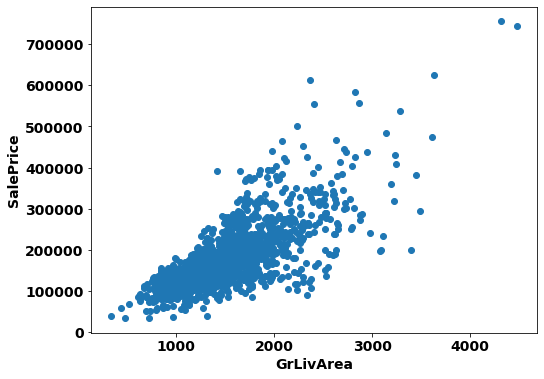

In [134]:
df_train1 = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)
df_train1 = df_train1.reset_index(drop=True)

scatterplot(df = df_train1, var1 = 'GrLivArea', var2 = 'SalePrice')

In [135]:
# We can see that this relationship is now also nice and linear :).

In [136]:
def Outlier_removal_IQR(df, var):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    df_IQR = df.loc[(df[var] >= (Q1 - 1.5*IQR)) & (df[var] <= Q3 + 1.5*IQR)]
    return df_IQR

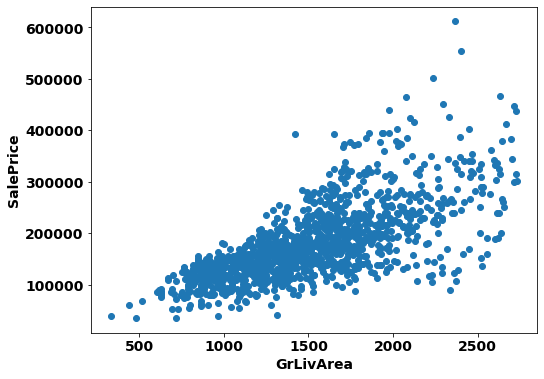

In [137]:
df_IQR = Outlier_removal_IQR(df = df_train, var = 'GrLivArea')
scatterplot(df = df_IQR, var1 = 'GrLivArea', var2 = 'SalePrice')

The removal of outliers is not always safe. We decided to delete these two as they are very extreme - i.e. extremely large areas for very low prices.

In [138]:
# Outlier removal using IQR
Q1 = df_train['GrLivArea'].quantile(0.25)
Q3 = df_train['GrLivArea'].quantile(0.75)
IQR = Q3 - Q1

In [139]:
df_train_IQR = df_train.loc[(df_train['GrLivArea'] >= 
                           (Q1 - 1.5*IQR)) & (df_train['GrLivArea'] <= Q3 + 1.5*IQR)]

In [140]:
df_IQR = Outlier_removal_IQR(df = df_train, var = 'TotalBsmtSF')

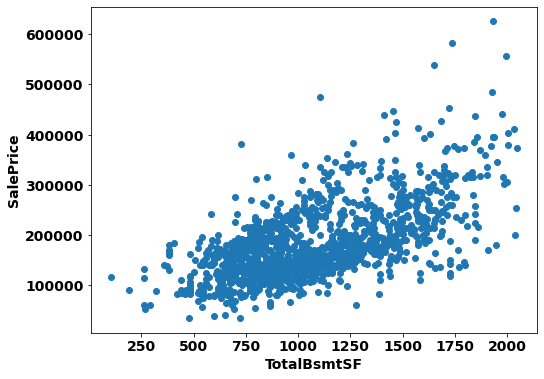

In [141]:
scatterplot(df = df_IQR, var1 = 'TotalBsmtSF', var2 = 'SalePrice')

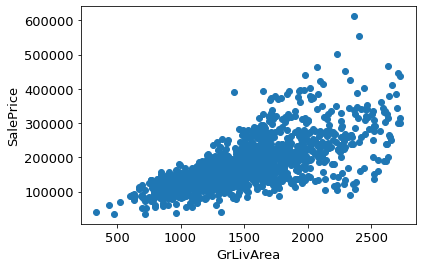

In [142]:
fig, ax = plt.subplots()
ax.scatter(df_train_IQR['GrLivArea'], df_train_IQR['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
# changing the fontsize of y & x ticks
plt.yticks(fontsize=13), plt.xticks(fontsize=13)
plt.show()

**Null Value Replacement**

In [143]:
missing_values_train = df_train.isnull().sum().sort_values(ascending=False)
missing_values_train=missing_values_train[missing_values_train>0]
missing_values_percent_train = ((df_train.isnull().sum()/df_train.isnull().count())*100).sort_values(ascending=False)
missing_values_percent_train=missing_values_percent_train[missing_values_percent_train>0]
missing_data_train = pd.concat([missing_values_train, missing_values_percent_train], axis=1, keys=['Missing Values', 'Missing Values %'])
missing_data_train

,Missing Values,Missing Values %
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


In [144]:
#Null Value Replacement

# As a first step, we will check whether we have some columns with missing values.

# missing data
#total = df_train.isnull().sum().sort_values(ascending=False)
#percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)*100
#missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#missing_data

There are a couple of columns, where most of the values are missing. We can get rid of these since they don't have any value for us.

In [145]:
missing_values_test = df_test.isnull().sum().sort_values(ascending=False)
missing_values_test=missing_values_test[missing_values_test>0]
missing_values_percent_test = ((df_test.isnull().sum()/df_test.isnull().count())*100).sort_values(ascending=False)
missing_values_percent_test=missing_values_percent_test[missing_values_percent_test>0]
missing_data_test = pd.concat([missing_values_test, missing_values_percent_test], axis=1, keys=['Missing Values', 'Missing Values %'])
missing_data_test.head()

,Missing Values,Missing Values %
PoolQC,1456,99.794380
MiscFeature,1408,96.504455
Alley,1352,92.666210
Fence,1169,80.123372
FireplaceQu,730,50.034270


In [146]:
len(missing_values_percent_train)

19

In [147]:
def boxplot_cat(var, df, rotation=0):
    data = df[['SalePrice',var]]
    fig, ax = plt.subplots(figsize=(12, 8))
    fig = sns.boxplot(x=var, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000)
    plt.title("SalePrice vs " +var,fontsize = 14,fontweight='bold')
    plt.xlabel(var,fontsize = 14,fontweight='bold')
    plt.ylabel("SalePrice",fontsize = 14,fontweight='bold')
    plt.xticks(fontsize=12,fontweight='bold');
    plt.yticks(fontsize=12,fontweight='bold');
    plt.xticks(rotation=rotation)

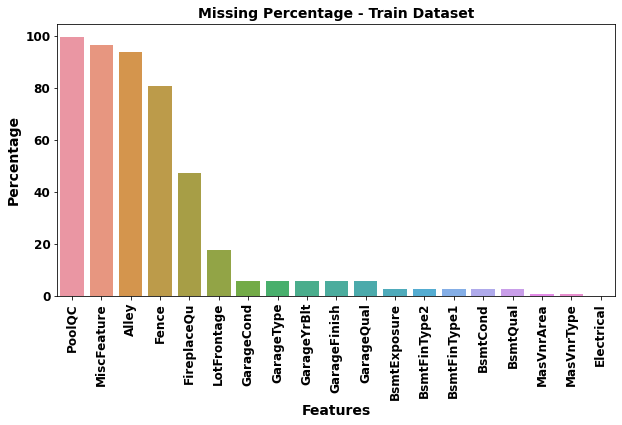

In [148]:
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='90')
sns.barplot(x=missing_values_percent_train.index, y=missing_values_percent_train)
plt.title('Missing Percentage - Train Dataset',fontsize = 14,fontweight='bold')
plt.xlabel('Features',fontsize = 14,fontweight='bold')
plt.ylabel('Percentage',fontsize = 14,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold');
plt.yticks(fontsize=12,fontweight='bold');
plt.show()

In [149]:
# drop 5 columns with the biggest ratio of null values
to_drop = missing_data_train.head(5).index.tolist()
df_train.drop(to_drop, axis=1, inplace=True)

In [150]:
def missing_values(df):
    missing_values = df.isnull().sum().sort_values(ascending=False)
    missing_values = missing_values[missing_values>0]
    missing_values_percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_values_percent = missing_values_percent[missing_values_percent>0]
    missing_data = pd.concat([missing_values, missing_values_percent], axis=1, keys=['Missing Values', 'Missing Values %'])
    return missing_data

In [151]:
def missing_data_plot(missing_values):
    f, ax = plt.subplots(figsize=(10, 5))
    plt.xticks(rotation='90')
    sns.barplot(x=missing_values.index, y=missing_values)
    plt.title('Missing Percentage - Train Dataset',fontsize = 14,fontweight='bold')
    plt.xlabel('Features',fontsize = 14,fontweight='bold')
    plt.ylabel('Percentage',fontsize = 14,fontweight='bold')
    plt.xticks(fontsize=12,fontweight='bold');
    plt.yticks(fontsize=12,fontweight='bold');
    plt.show()

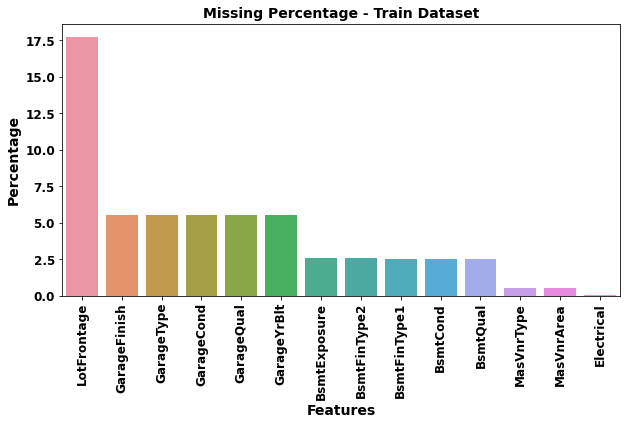

In [152]:
ddd = missing_values(df_train)
missing_data_plot(missing_values = ddd['Missing Values %'])

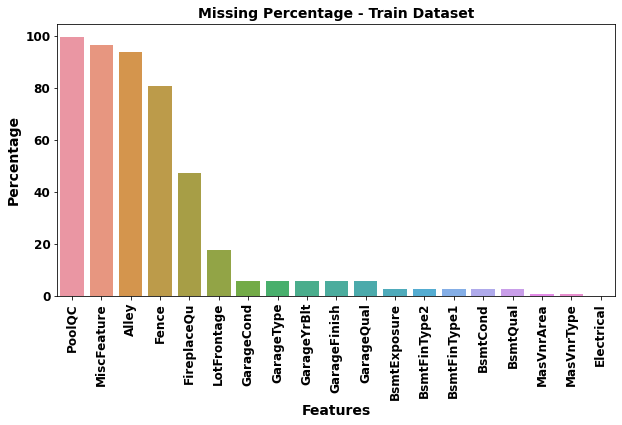

In [153]:

f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='90')
sns.barplot(x=missing_values_percent_train.index, y=missing_values_percent_train)
plt.title('Missing Percentage - Train Dataset',fontsize = 14,fontweight='bold')
plt.xlabel('Features',fontsize = 14,fontweight='bold')
plt.ylabel('Percentage',fontsize = 14,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold');
plt.yticks(fontsize=12,fontweight='bold');
plt.show()


Be careful when removing columns. Sometimes a column can give us some relevant information even if 50% of values are Null. It's always good to be cautious when removing columns.

We don't want to remove more than 5 columns because the rest don't have a lot of missing values.

Let's check the data types of the columns with missing values.



In [154]:
missing_values_train

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [155]:
# extract the names of columns with missing values
cols_with_missing = missing_data_train[missing_data_train['Missing Values %'] > 0].index.tolist()
# remove column names that are already removed from dataset
missing_cols = list(set(cols_with_missing) - set(to_drop))
# check the datatype
df_train.dtypes[missing_cols]
#We can see that we have a few numeric variables and some with text inside. First, we will take a look at the numeric ones.

Electrical       object
MasVnrArea      float64
GarageFinish     object
BsmtExposure     object
LotFrontage     float64
BsmtCond         object
GarageType       object
BsmtFinType2     object
GarageCond       object
BsmtFinType1     object
GarageQual       object
BsmtQual         object
MasVnrType       object
GarageYrBlt     float64
dtype: object

### Numeric Variables

We will create a separate column to keep the information whether the value was missing. This way, we will have this information available in this column after we replace the value in the original one.

In [156]:
num_cols_with_missing = df_train.dtypes[missing_cols][df_train.dtypes[missing_cols] == 'float'].index.tolist()
# create new variable with the information that it was missing
for cl in num_cols_with_missing:
    df_train[cl + "_missing_ind"] = 0
    df_train.loc[df_train[cl].isnull(), cl + "_missing_ind"] = 1

In [157]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MasVnrArea_missing_ind,LotFrontage_missing_ind,GarageYrBlt_missing_ind
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,208500,0,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,5,2007,WD,Normal,181500,0,0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,9,2008,WD,Normal,223500,0,0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,2,2006,WD,Abnorml,140000,0,0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,12,2008,WD,Normal,250000,0,0,0


In [158]:
#Now we can work on the Null value replacement.

In [159]:
df_train["LotFrontage"] = df_train["LotFrontage"].fillna(df_train["LotFrontage"].mean())
df_train["GarageYrBlt"] = df_train["GarageYrBlt"].fillna(df_train["GarageYrBlt"].min())
df_train["MasVnrArea"] = df_train["MasVnrArea"].fillna(0)

- LotFrontage – We replace the missing values with the mean.
- GarageYrBlt – If the house has a garage and the year is missing, we assume it's the minimum value available.
- MasVnrArea – If the veneer area is missing, we assume it's 0

In [160]:
#Object (String) Variables
#Find the variables with the dtype == "object" and having at least one missing value.

# 2. for categorical variables:
df_train.dtypes[missing_cols][df_train.dtypes[missing_cols] == 'object']
cat_cols_with_missing = df_train.dtypes[missing_cols][df_train.dtypes[missing_cols] == 'object'].index.tolist()

With the help of the data documentation we have, we can figure out that the missing values in Garage and Basement variables mean no garage and no basement respectively. Therefore, we will replace the missing values with "None"

In [161]:
# GarageFinish : data description says NA means "no garage"
df_train["GarageFinish"] = df_train["GarageFinish"].fillna("None")
# GarageCond : data description says NA means "no garage"
df_train["GarageCond"] = df_train["GarageCond"].fillna("None")
# GarageQual : data description says NA means "no garage"
df_train["GarageQual"] = df_train["GarageQual"].fillna("None")
# GarageType : data description says NA means "no garage"
df_train["GarageType"] = df_train["GarageType"].fillna("None")

# BsmtExposure : data description says NA means "no basement"
df_train["BsmtExposure"] = df_train["BsmtExposure"].fillna("None")
# BsmtFinType2 : data description says NA means "no basement"
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].fillna("None")
# BsmtFinType1 : data description says NA means "no basement"
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].fillna("None")
# BsmtCond : data description says NA means "no basement"
df_train["BsmtCond"] = df_train["BsmtCond"].fillna("None")
# BsmtQual : data description says NA means "no basement"
df_train["BsmtQual"] = df_train["BsmtQual"].fillna("None")

The information about Electrical and MasVnrType is missing in the documentation. Since we are dealing with categorical variables, we will create a new category for a missing value.

In [162]:
#df_train.columns.tolist()

In [163]:
df_train["Electrical"] = df_train["Electrical"].fillna("Empty")
df_train["MasVnrType"] = df_train["MasVnrType"].fillna("Empty")

In [164]:
ddd = missing_values(df_train)
#missing_data_plot(missing_values = ddd['Missing Values %'])

In [165]:
ddd

,Missing Values,Missing Values %


**Variable Transformation**

In [166]:
# Variable Transformation

#Since we are going to apply different transformations to different data types,
# we start by extracting the numeric feature names:

num_feats = df_train.dtypes[df_train.dtypes != 'object'].index.tolist()

In [167]:
def dist_plot(data,var, prop = True):
    fig = plt.figure(figsize = (10,8))
    sns.distplot(data, fit= norm)
    plt.title(var+" Distribution",fontsize = 14,fontweight='bold')
    plt.xlabel(var,fontsize = 14,fontweight='bold')
    plt.ylabel("Frequency",fontsize = 14,fontweight='bold')
    plt.xticks(fontsize=14,fontweight='bold')
    plt.yticks(fontsize=14,fontweight='bold')
    if prop != True:
        pass
    else:
        fig = plt.figure(figsize = (10,8))
        res = stats.probplot(data, plot= plt)
        plt.title("Probability Plot",fontsize = 14,fontweight='bold')
        plt.xlabel("Theoretical Quantiles",fontsize = 14,fontweight='bold')
        plt.ylabel("Ordered Values",fontsize = 14,fontweight='bold')
        plt.xticks(fontsize=14,fontweight='bold');
        plt.yticks(fontsize=14,fontweight='bold');

In [168]:
print(f"Skewness: {df_train.SalePrice.skew()}")
print(f"Kurtosis: {df_train.SalePrice.kurt()}")

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


F:\ANACONDA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


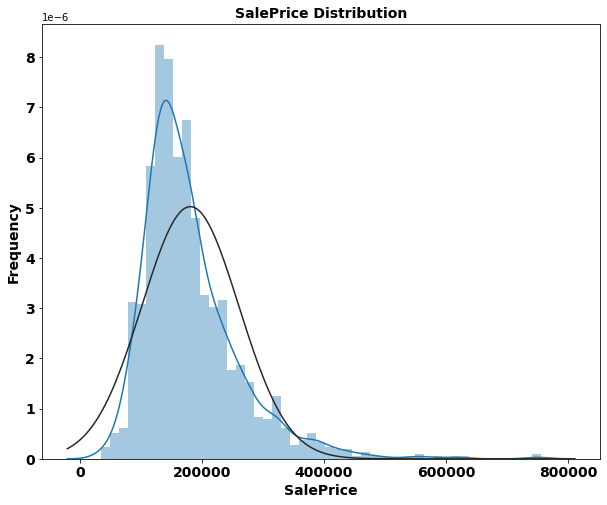

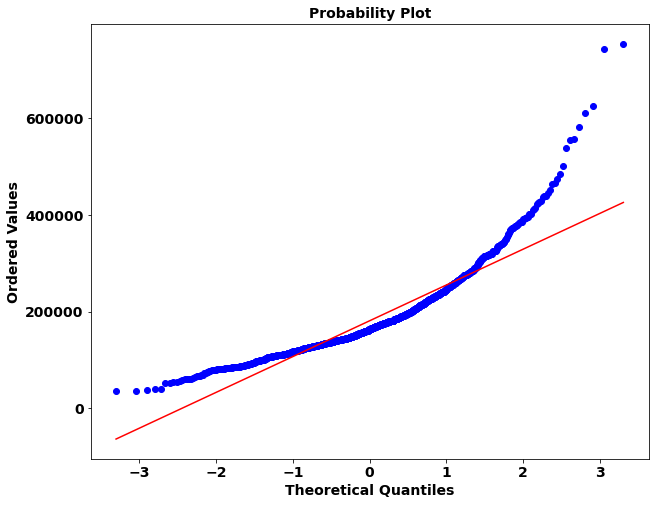

In [169]:
dist_plot(data = df_train.SalePrice,var = 'SalePrice', prop = True)

In [170]:
df = df_train.copy(deep=True)
df1 = df_train.copy(deep=True)

F:\ANACONDA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


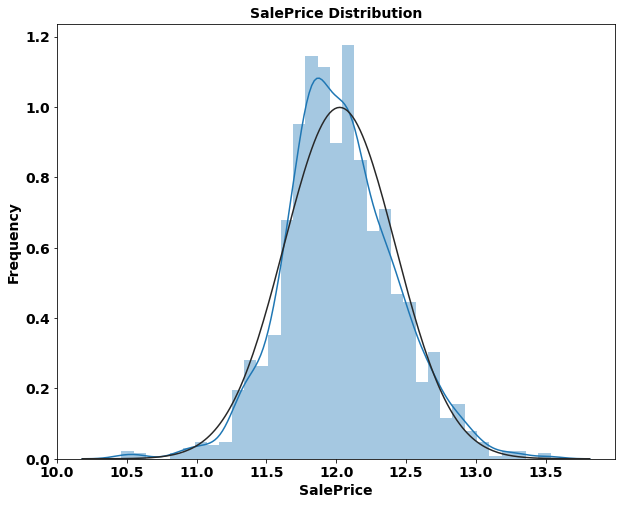

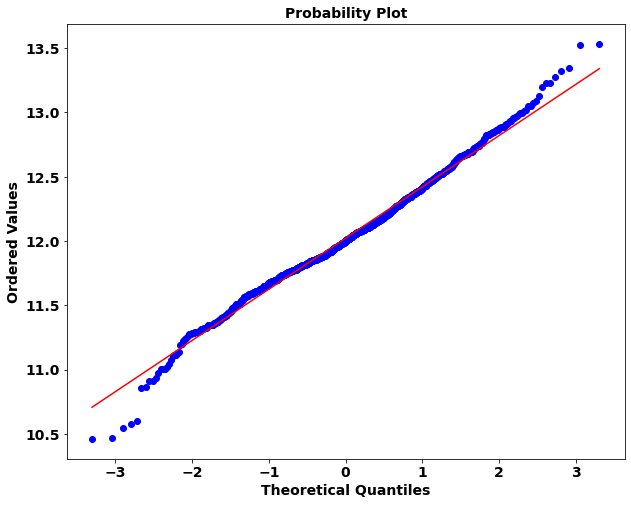

In [171]:
# First, we fix skewness in 'SalePrice'
sale_price = df['SalePrice']
sale_price = np.log1p(sale_price)
dist_plot(data = sale_price,var = 'SalePrice', prop = True)

Now, we log transform skewed numerical variables.

In [172]:
# skewness and kurtosis
print(f"Skewness: {sale_price.skew()}")
print(f"Kurtosis: {sale_price.kurt()}")
# The SalePrice is positive skewed, and show peakedness.

Skewness: 0.12134661989685333
Kurtosis: 0.809519155707878


F:\ANACONDA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


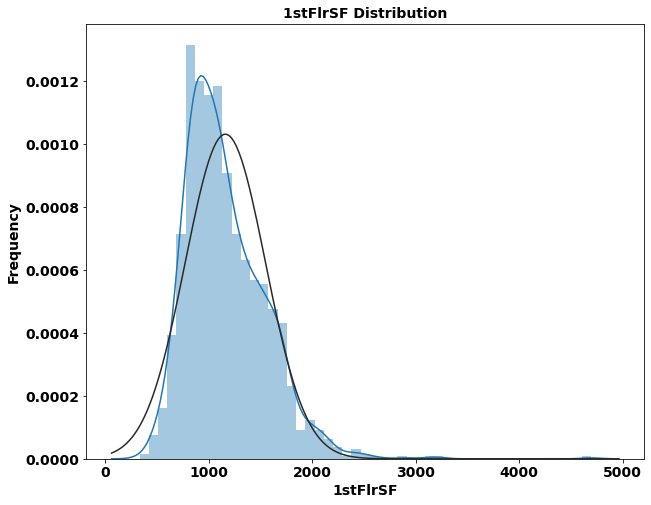

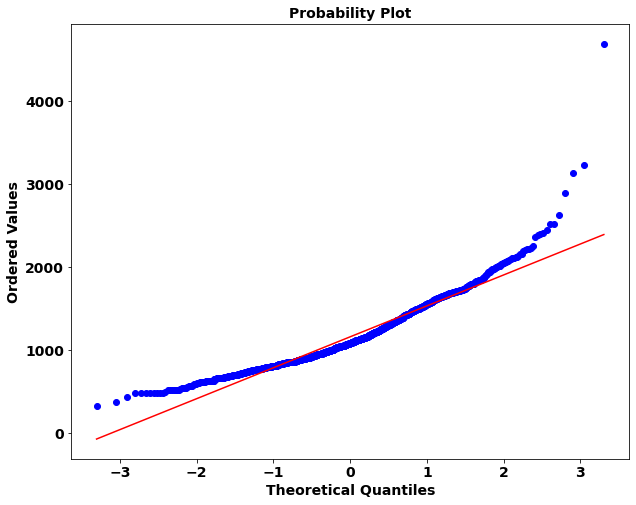

In [173]:
dist_plot(data = df_train['1stFlrSF'],var = '1stFlrSF', prop = True)

F:\ANACONDA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


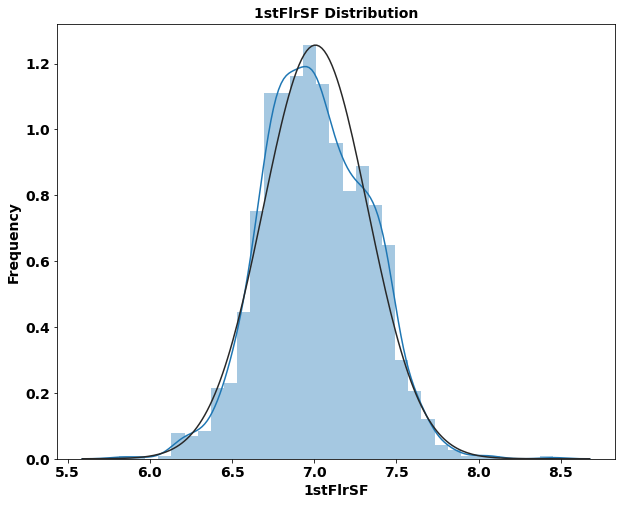

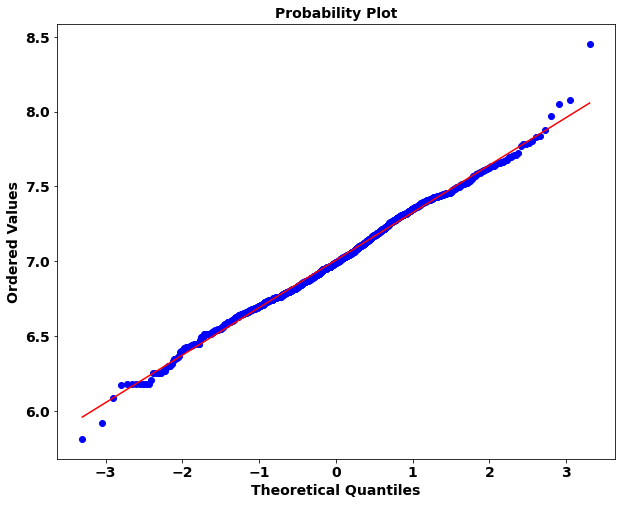

In [174]:
# We will apply the logarithmic transformation:
# log transformation
df["1stFlrSF_log"] = df["1stFlrSF"].apply(np.log)
dist_plot(data = df['1stFlrSF_log'],var = '1stFlrSF', prop = True)


We can see in the graph above that the logarithmic transformation of the variable is more** normal.

Furthermore, we will look at scaling. In sklearn there are plenty of different options. We will use the StandardScaler. Scaling is important for some algorithms that require to have values with the same scale, for example between 0 and 1.

In [175]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler()
#.fit(df_train[num_feats])

# transform training data
#df_train_norm = norm.transform(df_train[num_feats])

#scaler = StandardScaler()
#df_train_norm = pd.DataFrame(df_train_norm.astype(float))
df_train_norm = pd.DataFrame(norm.fit_transform(df[num_feats].astype(float)))

In [176]:
df_train_norm.columns = num_feats
#df_train_scaled.columns = num_feats

In [177]:
# Scaling
from sklearn.preprocessing import StandardScaler
# 
scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df1[num_feats].astype(float)))

In [178]:
df_train_scaled

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,-1.730865,0.073375,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,...,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273,-0.074227,-0.464385,-0.24236
1,-1.728492,-0.872563,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,...,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.007288,-0.074227,-0.464385,-0.24236
2,-1.726120,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,...,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154,-0.074227,-0.464385,-0.24236
3,-1.723747,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,...,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281,-0.074227,-0.464385,-0.24236
4,-1.721374,0.073375,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,...,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.869843,-0.074227,-0.464385,-0.24236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.365633,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,...,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439,-0.074560,-0.074227,-0.464385,-0.24236
1456,1.723747,-0.872563,0.679039,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,...,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,1.645210,0.366161,-0.074227,-0.464385,-0.24236
1457,1.726120,0.309859,-0.183951,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,...,-0.116339,-0.270208,-0.068692,4.953112,-0.489110,1.645210,1.077611,-0.074227,-0.464385,-0.24236
1458,1.728492,-0.872563,-0.093110,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,...,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110,1.645210,-0.488523,-0.074227,-0.464385,-0.24236


fit_transform returns data typenumpy.array so once we convert results back to Pandas DataFrame there won't be any original column names. We need to add column names using DataFrame attribute .columns.

In [179]:
print(df_train_scaled.columns)

RangeIndex(start=0, stop=41, step=1)


In [180]:
# Assign original column names to the DataFrame df_train_scaled.
df_train_scaled.columns = num_feats
print(df_train_scaled.columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'MasVnrArea_missing_ind',
       'LotFrontage_missing_ind', 'GarageYrBlt_missing_ind'],
      dtype='object')


In [181]:
df_train_scaled

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MasVnrArea_missing_ind,LotFrontage_missing_ind,GarageYrBlt_missing_ind
0,-1.730865,0.073375,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,...,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273,-0.074227,-0.464385,-0.24236
1,-1.728492,-0.872563,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,...,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.007288,-0.074227,-0.464385,-0.24236
2,-1.726120,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,...,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154,-0.074227,-0.464385,-0.24236
3,-1.723747,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,...,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281,-0.074227,-0.464385,-0.24236
4,-1.721374,0.073375,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,...,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.869843,-0.074227,-0.464385,-0.24236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.365633,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,...,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439,-0.074560,-0.074227,-0.464385,-0.24236
1456,1.723747,-0.872563,0.679039,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,...,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,1.645210,0.366161,-0.074227,-0.464385,-0.24236
1457,1.726120,0.309859,-0.183951,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,...,-0.116339,-0.270208,-0.068692,4.953112,-0.489110,1.645210,1.077611,-0.074227,-0.464385,-0.24236
1458,1.728492,-0.872563,-0.093110,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,...,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110,1.645210,-0.488523,-0.074227,-0.464385,-0.24236


### String Variables

We know two types of string variables:
 - Categorical (Nominal)
 - Ordinal
 
The difference is that with an ordinal variable, we can order the categories by importance/value/score. For example marks at school. Even though it is a string variable with "categories" A, B,..., F, we can order them A>B>C>D>E>F.

Therefore, we can transform the ordinal variables into numbers and create numeric variables out of them. We will use the help of our documentation to understand the sorting.

In [182]:
# lets map ORDINAL features
df_train = df_train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                           "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                           "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                             "ALQ" : 5, "GLQ" : 6},
                           "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                             "ALQ" : 5, "GLQ" : 6},
                           "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                           "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                           "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                           "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5,
                                           "Min2" : 6, "Min1" : 7, "Typ" : 8},
                           "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                           "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                           "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                           "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                           "Street" : {"Grvl" : 1, "Pave" : 2},
                           "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                         )

For categorical features, our options are quite limited. By far the most often used transformation is the creation of Dummy variables.

In [183]:
cat_feats = df_train.dtypes[df_train.dtypes == 'object'].index.tolist()
df_dummy = pd.get_dummies(df_train[cat_feats])

In [184]:
cat_feats

['MSZoning',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'BsmtExposure',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'SaleType',
 'SaleCondition']

In [187]:
# Saving processed dataset
df_train.to_csv('df_train_processed.csv', index=False)